In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis

Mounted at /content/drive
/content/drive/MyDrive/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/hc-rl-thompson-sampling/sepsis/custom_sepsis/src')

In [3]:
!pip install gymnasium
!pip install stable_baselines3
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.3 MB/s eta 0:00:00


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from custom_sepsis import *

In [5]:
import numpy as np
import random
from sepsis_env import SepsisEnv
from concurrent.futures import ThreadPoolExecutor


In [20]:
# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.01  # Initial exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon
epsilon_min = 0.001 # Minimum epsilon value
n_episodes = 30000  # Number of episodes to train

# Function to run Q-learning
def q_learning_run(run_id):
    env = SepsisEnv()
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    epsilon = 1.0
    rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            # Take action in the environment
            next_state, reward, done, truncated, _ = env.step(action)
            if(done):
                rewards.append(reward)

            # Update Q-value
            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state, best_next_action] * (not done)
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            # Update state and accumulate reward
            state = next_state
            total_reward += reward

        # Decay epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # Log progress every 500 episodes
        if (episode + 1) % 500 == 0:
            print(f"Run {run_id}: Episode {episode + 1}/{n_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    # Extract policy from Q-table
    policy = {STATES[state]: ACTIONS[np.argmax(q_table[state])] for state in range(env.observation_space.n)}
    return rewards, policy, q_table


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Run 3 Q-learning instances in parallel
n_runs = 100
with ThreadPoolExecutor(max_workers=n_runs) as executor:
    futures = [executor.submit(q_learning_run, run_id) for run_id in range(n_runs)]
    results = [future.result() for future in futures]


Run 0: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 3: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 5: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 1: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 2: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 8: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 6: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 4: Episode 500/3500, Total Reward: 0, Epsilon: 0.08
Run 9: Episode 500/3500, Total Reward: 0, Epsilon: 0.08
Run 7: Episode 500/3500, Total Reward: 0, Epsilon: 0.08
Run 12: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 11: Episode 500/3500, Total Reward: 0, Epsilon: 0.08
Run 15: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 17: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 13: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 16: Episode 500/3500, Total Reward: -1, Epsilon: 0.08
Run 22: Episode 500/3500, Total Reward: 0, Epsilon: 0.08
Run 26: Episode 500/3500, Tot

In [30]:
mean_rewards = np.mean([run[0] for run in results], axis=0)

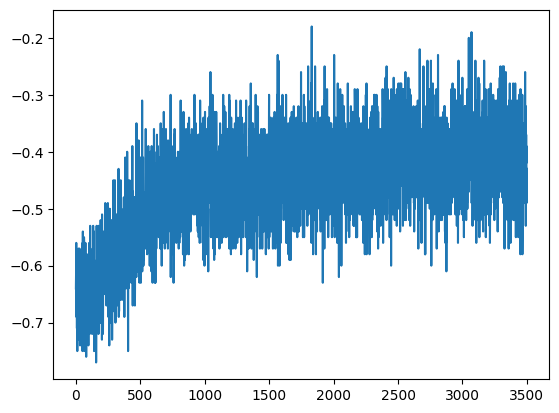

In [31]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)

In [ ]:
# prompt: compute smoothed mean across mean rewards using window size 100

import numpy as np

window_size = 100
min_length = min(len(rewards[0]) for rewards in results)

smoothed_mean_rewards = np.convolve(mean_rewards, np.ones(window_size), 'valid') / window_size
smoothed_std = np.std([np.convolve(rewards[0][:min_length], np.ones(100)/100, mode='valid') for rewards in results], axis=0)

plt.plot(smoothed_mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Smoothed Mean Reward')
plt.title('Smoothed Mean Reward over Episodes (Window Size = 100)')
plt.show()

In [33]:
import json

# Prepare the data for JSON
q_learning_data = {
    "name": "Q_Learning",
    "info": {
        "description": "Mean rewards across 100 q-learning runs over 100000 episodes.",
        "nr_episodes": n_episodes,
        "epsilon": epsilon,
        "epsilon_decay": epsilon_decay,
        "epsilon_min": epsilon_min,
        "alpha": alpha,
        "gamma": gamma,
        "n_runs": n_runs
    },
    "mean_rewards": mean_rewards.tolist(), # Convert numpy array to list
    "smoothed_mean": smoothed_mean_rewards.tolist(),
    "smoothed_std": smoothed_std.tolist(),
    "keys_of_smoothed": [i+1 for i in range(len(smoothed_mean_rewards))],
    "individual_runs": [run[0] for run in results] # include all runs for further analysis
}


# Save the data to a JSON file
with open("q_learning_results.json", "w") as f:
    json.dump(q_learning_data, f, indent=4)

# Download the file
from google.colab import files
files.download("q_learning_results.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>